# **Tutorial 5: Paleoclimate Data Analysis Tools**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Brodie Pearson, Ohad Zivan 

**Content editors:** Yosmely Bermúdez, Agustina Pesce, Zahra Khodakaramimaghsoud

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS


## **Code and Data Sources**

Code for this tutorial is based on existing notebooks from LinkedEarth for [anlayzing LiPD datasets](https://github.com/LinkedEarth/paleoHackathon/blob/main/notebooks/PaleoHack-nb03_EDA.ipynb) and [resampling data with `Pyleoclim`](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L1_uniform_time_sampling.ipynb).

Data from the following sources are used in this tutorial:

*   Tierney, J.E., et al. 2008. Northern Hemisphere Controls on Tropical Southeast African Climate During the Past 60,000 Years. Science, Vol. 322, No. 5899, pp. 252-255, 10 October 2008. https://doi.org/10.1126/science.1160485.
*   Tierney, J.E., and deMenocal, P.. 2013. Abrupt Shifts in Horn of Africa Hydroclimate Since the Last Glacial Maximum. Science, 342(6160), 843-846. https://doi.org/10.1126/science.1240411.
*   Tierney, J.E., Pausata, F., deMenocal, P. 2017. Rainfall Regimes of the Green Sahara. Science Advances, 3(1), e1601503. https://doi.org/10.1126/sciadv.1601503. 
*   Shanahan, T.M., et al. 2015. The time-transgressive termination of the African Humid Period. Nature Geoscience, 8(2), 140-144. https://doi.org/10.1038/ngeo2329.

















# **Tutorial Objectives**

In this tutorial, you will explore various computational analyses for interpreting paleoclimate data and understand why these methods are useful. A common issue in the paleoclimate is the presence of uneven time spacing between consecutive observations. `Pyleoclim` includes several methods that can deal with uneven sampling effectively, but there are certain applications and analyses for which it's ncessary to place the records on a uniform time axis. In this tutorial you'll learn a few ways to do this with `pyleoclim`. Additionally, we will explore another useful paleoclimate data analysis tool, Principal Component Analysis (PCA), which allows us to identify a common signal between various paleoclimate reconstructions. 

By the end of this tutorial you'll be able to perform the following data analysis techniques on proxy-based climate reconstructions:

*   Interpolation
*   Binning 
*   Principal component analysis


In [1]:
# # Install libraries
# !pip install cartopy
# !pip install pyleoclim
# !pip install pandas
# !pip install matplotlib

In [2]:
# Import libraries
import pandas as pd
import cartopy
import pyleoclim as pyleo
import matplotlib.pyplot as plt

# **Section 1: Load the sample dataset for analysis**

For this tutorial, we are going to use an example dataset to practice the various data analysis techniques. The dataset we'll be using is a record of hydrogen isotopes of leaf waxes (δD<sub>wax</sub>) from Lake Tanganyika in East Africa [(Tierney et al., 2008)](https://www.science.org/doi/10.1126/science.1160485?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed). Recall from the video that δD<sub>wax</sub> is a proxy that records changes in the amount of precipitation in the tropics. In the previous tutorial, we looked at δD data from high-latitude ice cores. In that case, δD was a proxy for temperature, but in the tropics, δD reflects rainfall amount, as explained in the introductory video.

Let's first read the data from a .csv file.

In [3]:
import pooch

# fname = 'tanganyika_dD.csv'
url = "https://osf.io/sujvp/download/"
data_path = pooch.retrieve(
    url,
    known_hash=None
)

tang_dD = pd.read_csv(data_path)

In [4]:
tang_dD.head()

,Age,dD,dD_IVbio,dD_IVonly,d13C
0,1405,-105.2,-15.6,-105.1,-31.4
1,1769,-97.3,-6.9,-97.2,-30.7
2,1997,-93.7,-2.8,-93.5,-30.4
3,2316,-107.8,-18.5,-107.8,-29.8
4,2545,-103.1,-13.5,-103.2,-30.4


We can now create a `Series` in Pyleoclim and assign names to different variables so that we can easily plot the data.

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [yr BP]', ylabel='dDwax [per mille]'>)

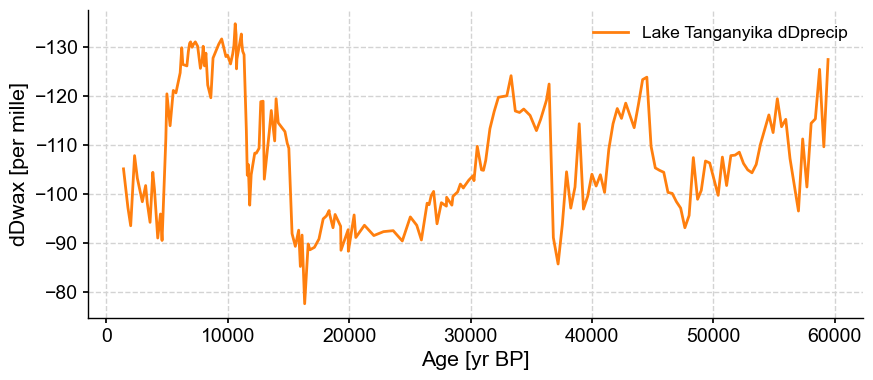

In [5]:
ts_tang = pyleo.Series(
    time=tang_dD['Age'],
    value= tang_dD['dD_IVonly'],
    time_name='Age',
    time_unit='yr BP',
    value_name='dDwax',
    value_unit='per mille',
    label='Lake Tanganyika dDprecip'
)

ts_tang.plot(color='C1',invert_yaxis=True)

You may notice that the y-axis is inverted. When we're plotting δD data, we typically invert the y-axis because more negative ("depleted") values suggest increased rainfall, whereas more positive ("enriched") values suggest decreased rainfall.

Looking at the δD time series you just created, how has precipitation in this region varied over the past 60,000 years?

# **Section 2: Uniform Time-Sampling of the Data**
There is a number of different reasons we might want to assign new values to our data. For example, if the data is not evenly spaced, we might need to resample to even time spacing in order to use some other data analysis technique or to more easily compare to other data of different sampling resolutions. 

First, let's check whether our data is already evenly spaced using the `.is_evenly_spaced()` method:

In [6]:
ts_tang.is_evenly_spaced()

False

Our data is not evenly spaced. There are a few different methods available in `pyleoclim` to place the data on a uniform axis, and in this tutorial, we'll explore two methods: interpolating and binning. In general, these methods use the available data near a chosen time to estimate what the value was at that time, but each method differs in which nearby data points it uses and how it uses them.


## **Section 2.1: Interpolation**
To start out, let's try using interpolation to evenly space our data. Interpolation projects the data onto an evenly spaced time axis with a distance between points (step size) of our choosing. There are a variety of different methods by which the data can be interpolated, these being: `linear`, `nearest`, `zero`, `slinear`, `quadratic`, `cubic`, `previous`, and `next`. More on these and their associated key word arguments can be found in the [documentation](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.interp). By default, the function `.interp()` implements linear interpolation:

In [7]:
tang_linear = ts_tang.interp() #default method = 'linear'

In [8]:
#Checking whether or not the series is now evenly spaced
tang_linear.is_evenly_spaced()

True

Now that we've interpolated our data, let's compare the original dataset to the linearly interpolated dataset we just created.

<Axes: xlabel='Age [yr BP]', ylabel='dDwax [per mille]'>

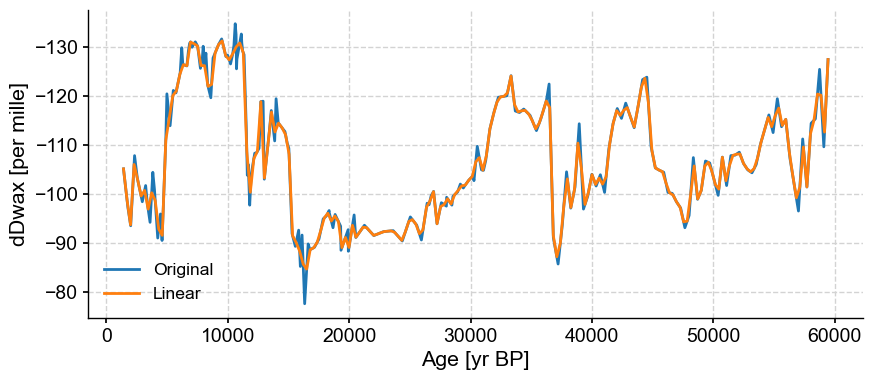

In [9]:
fig, ax = ts_tang.plot(label='Original')
tang_linear.plot(ax=ax, label='Linear', invert_yaxis=True)

Notice that although there are some minor differences between the original and linearly interpolated data, the records are essential the same.

You can print the data in the original and interpolated time series to see the difference in the ages between the two datasets. The interpolated dataset is now evenly spaced with a δD value every ~290 years.

In [10]:
ts_tang

{'label': 'Lake Tanganyika dDprecip'}


None
Age [yr BP]
1405.0    -105.1
1769.0     -97.2
1997.0     -93.5
2316.0    -107.8
2545.0    -103.2
           ...  
58061.0   -114.4
58409.0   -115.3
58757.0   -125.4
59105.0   -109.6
59454.0   -127.4
Name: dDwax [per mille], Length: 201, dtype: float64

In [11]:
tang_linear

{'label': 'Lake Tanganyika dDprecip'}


None
Age [yr BP]
1405.000    -105.100000
1695.245     -98.800727
1985.490     -93.686785
2275.735    -105.995017
2565.980    -102.954380
                ...    
58293.020   -115.000052
58583.265   -120.357691
58873.510   -120.110178
59163.755   -112.596673
59454.000   -127.400000
Name: dDwax [per mille], Length: 201, dtype: float64

Let's compare a few of the different interpolation methods (e.g., quadratic, next, zero) with one another just to see how they are similar and different:

In [12]:
tang_quadratic = ts_tang.interp(method='quadratic')
tang_next = ts_tang.interp(method='next')
tang_zero = ts_tang.interp(method='zero')

<Axes: xlabel='Age [yr BP]', ylabel='dDwax [per mille]'>

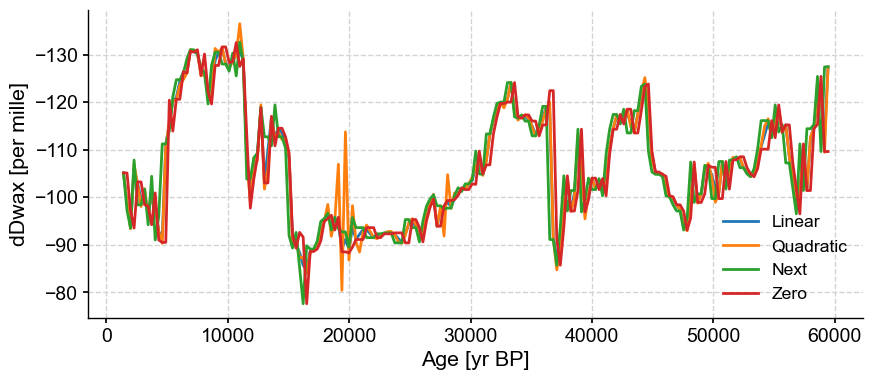

In [13]:
fig, ax = tang_linear.plot(label='Linear',invert_yaxis=True)
tang_quadratic.plot(ax=ax,label='Quadratic')
tang_next.plot(ax=ax,label='Next')
tang_zero.plot(ax=ax,label='Zero')

You can see how the methods can produce slightly different results, but reproduce the same overall trend.

## **Section 2.2: Binning**
Another option for resampling our data onto a uniform time axis is binning. Binning is when a set of time intervals is defined and data is grouped or binned with other data in the same interval, then all those points in a "bin" are averaged to get a data value for that bin. The defaults for binning pick a bin size at the coarsest time spacing present in the dataset and average data over a uniform sequence of such intervals. 

In [14]:
tang_bin = ts_tang.bin() #default settings pick the coarsest time spacing in the data as the binning period

<Axes: xlabel='Age [yr BP]', ylabel='dDwax [per mille]'>

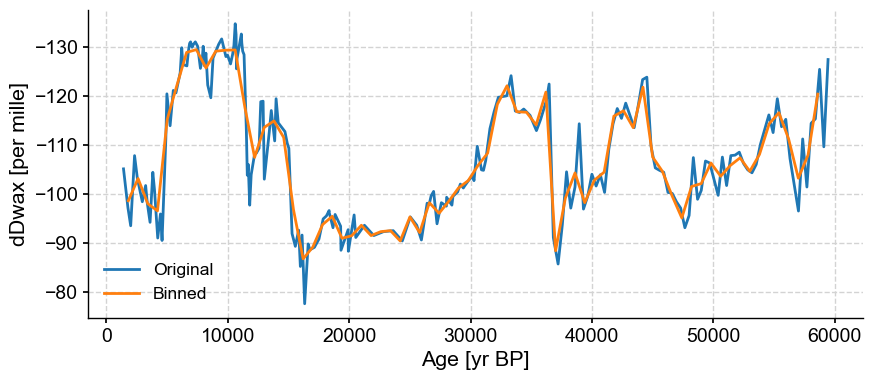

In [15]:
fig, ax = ts_tang.plot(label='Original',invert_yaxis=True)
tang_bin.plot(ax=ax,label='Binned')

Again, notice that although there are some minor differences between the original and binned data, the records still capture the same overall trend.

You can experiment with different bin sizes to see how this affects the resampling. You can do so by adding  `bin_size = ` to `ts_tang.bin()`. For example, you can try a bin size of 500 years, 1,000 years, etc.

# **Section 3: Principal Component Analysis (PCA)**
Principal Component Analysis (PCA) is a tool that allows us to identify a common signal between various paleoclimate reconstructions. Additional details about PCA can be found [here](https://builtin.com/data-science/step-step-explanation-principal-component-analysis). In order to calculate the PCA of multiple paleoclimate time series, all of the records need to be on a common time-step. To do so, we can applying the resampling tools we've learned so far in this tutorial.



So far, we've been looking at δD data from Lake Tanganyika in tropical East Africa. Let's compare this δD record to other existing δD records from lake and marine sediment cores in tropical Africa from the Gulf of Aden [(Tierney and deMenocal, 2017)](https://doi.org/10.1126/science.1240411), Lake Bosumtwi [(Shanahan et al., 2015)](https://doi.org/10.1038/ngeo2329), and the West African Margin [(Tierney et al., 2017)](https://doi.org/10.1126/sciadv.1601503).

First, let's load these datasets:

In [16]:
# Gulf of Aden
# fname = 'aden_dD.csv'
url = "https://osf.io/gm2v9/download/"

data_path = pooch.retrieve(
    url,
    known_hash=None
)

aden_dD = pd.read_csv(data_path)
aden_dD.head()

,depth_cm,age_calBP95-,age_calBP,age_calBP95+,dDwax,dDwaxIVcorr
0,1.25,-21,0,23,-128.9,-128.9
1,7.50,105,138,170,-128.3,-128.3
2,11.50,183,226,265,-133.6,-133.6
3,16.50,279,335,383,-133.6,-133.6
4,21.50,376,442,500,-138.1,-138.1


In [17]:
#Lake Bosumtwi
# fname = "bosumtwi_dD.csv"
url = "https://osf.io/mr7d9/download/"

data_path = pooch.retrieve(
    url,
    known_hash=None
)

bosumtwi_dD = pd.read_csv(data_path)

bosumtwi_dD.head()

,age_calBP,d13CleafwaxC31,d2HleafwaxC31ivc
0,68.8162,-28.40,-19.463969
1,217.1656,-30.12,-19.605047
2,360.0397,-31.00,-12.654186
3,404.7102,-28.90,-15.056285
4,488.1144,-29.94,-13.752030


In [18]:
# GC27 (West African Margin)
# fname = "gc27_dD.csv"
url = "https://osf.io/k6e3a/download/"

data_path = pooch.retrieve(
    url,
    known_hash=None
)

gc27_dD = pd.read_csv(data_path)
gc27_dD.head()

,depth_cm,age_BP,dDwax,dDwax_iv,d13Cwax,dDP
0,2.5,867,-130.2,-130.2,-30.64,-16.6
1,5.5,1345,-135.3,-135.2,-31.13,-22.8
2,9.5,2133,-131.7,-131.6,-30.85,-18.6
3,11.5,2535,-131.9,-131.9,-30.33,-18.1
4,14.5,3141,-132.1,-132.3,-30.07,-18.3


Next, let's convert each dataset into a `Series` in Pyleoclim.

In [19]:
ts_tanganyika = pyleo.Series(
    time=tang_dD['Age'],
    value= tang_dD['dD_IVonly'],
    time_name='Age',
    time_unit='yr BP',
    value_name='dDwax',
    label='Lake Tanganyika'
)
ts_aden = pyleo.Series(
    time=aden_dD['age_calBP'],
    value= aden_dD['dDwaxIVcorr'],
    time_name='Age',
    time_unit='yr BP',
    value_name='dDwax',
    label='Gulf of Aden'
)
ts_bosumtwi = pyleo.Series(
    time=bosumtwi_dD['age_calBP'],
    value=bosumtwi_dD['d2HleafwaxC31ivc'],
    time_name='Age',
    time_unit='yr BP',
    value_name = 'dDwax',
    label='Lake Bosumtwi'
)
ts_gc27 = pyleo.Series(
    time=gc27_dD['age_BP'],
    value=gc27_dD['dDwax_iv'],
    time_name='Age',
    time_unit='yr BP',
    value_name='dDwax',
    label='GC27'
)

Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order


Now let's set up a `MultipleSeries` using Pyleoclim with all four δD datasets. 

In [20]:
ts_list = [ts_tanganyika, ts_aden, ts_bosumtwi, ts_gc27]
ms_africa = pyleo.MultipleSeries(ts_list, name='African dDwax')

/var/folders/km/7y6kh21s71l26qj_cfmykzg40000gn/T/ipykernel_50757/2295575256.py:2: DeprecationWarning: `name` is a deprecated property, which will be removed in future releases, Please use `label` instead
  ms_africa = pyleo.MultipleSeries(ts_list, name='African dDwax')


We can now create a stackplot with all four δD records:

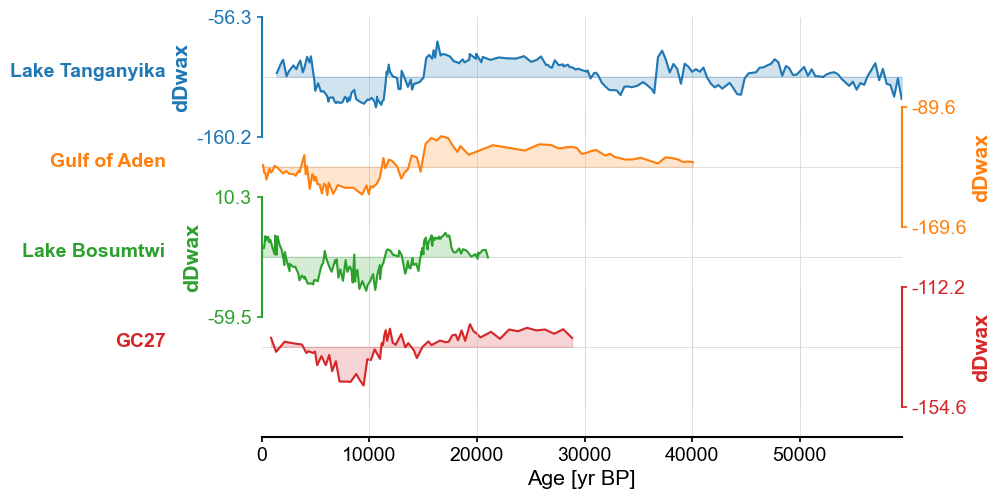

In [21]:
fig, ax = ms_africa.stackplot()

By creating a stackplot, we can easily compare between the datasets. However, the four δD records aren't the same resolution and don't span the same time interval.

To better compare the records and assess a common trend, we can use PCA. First, we can use `.common_time()` to place the records on a shared time axis with a common sampling frequency. Let's set the time step 500 years and standarize the data:

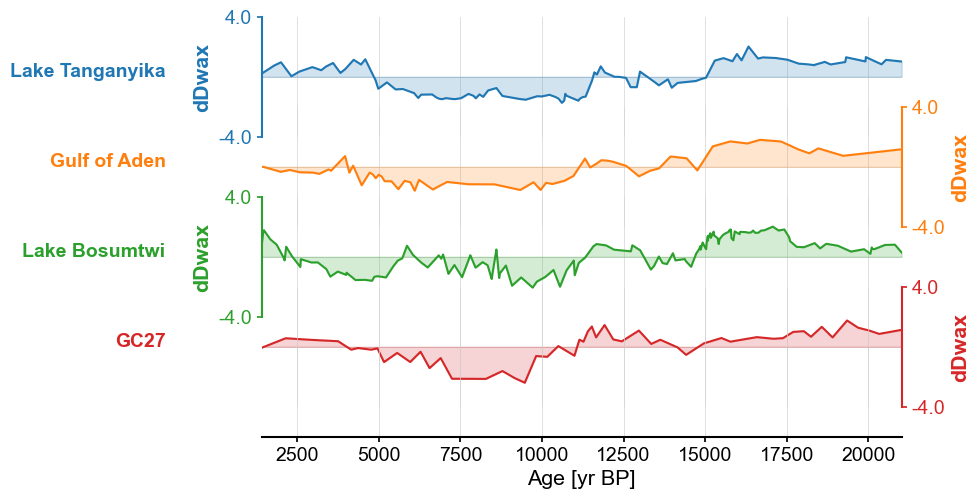

In [22]:
africa_ct = ms_africa.common_time(step=0.5).standardize()
fig, ax = africa_ct.stackplot()

We now have standardized δD records that are the same sampling resolution and span the same time interval. Before doing the PCA, what initial observations can you make about precipitation recorded in each δD record? Are the trends in precipitation over the past 20,000 years similar or different in each record?

We can now apply PCA which will allow us to quantitatively identify a common signal between the four δD paleoclimate reconstructions:

In [ ]:
PCA = africa_ct.pca()

The result is an object containing multiple outputs, and with two plotting methods attached to it. The two outputs we'll look at are pctvar (the variance) and pcs (the principal components). 

First, let's print the percentage of variance accounted for by each mode, which is saved as pctvar:

In [ ]:
print(PCA.pctvar.round())

This means that 97% of the variance in the four paleoclimate records is explained by the first principal component. The number of datasets in the PCA constrains the number of principal components that can be defined, which is why we only have four components in this example.

We can now look at the principal component of the first mode of variance. Let's create a new series for the first mode of variance and plot it against the original datasets:

In [ ]:
pc1 = PCA.pcs

In [ ]:
mode1 = pyleo.Series(
    time=africa_ct.series_list[0].time,
    value=PCA.pcs[:,0],
    label=r'$PC_1$',
    value_name='PC1',
    time_name ='age',
    time_unit = 'yr BP'
)

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_ylabel('dDwax')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('PC1')  # we already handled the x-label with ax1

#plt.plot(mode1.time,pc1_scaled)
mode1.plot(color='black', ax=ax2, invert_yaxis=True)
africa_ct.plot(ax=ax1, linewidth=0.5)

The original δD records are shown in the colored lines, and the first principal component (PC1) time series is shown in black. Consider the following questions to interpret the PC1 time series and assess past changes in precipitation in this region:
 

*   How do the original time series compare to the PC1 time series? Do they record similar trends?
*   Which original δD record most closely resembles the PC1 time series?
*   What changes in climate does the PC1 time series record over the past 20,000 years? *Hint: remember that more depleted δD suggests increased rainfall.*




 

In [1]:
## to remove the explanation  
"""
Please write your observations here
"""


'\nPlease write your observations here\n'

# **Summary**
In this tutorial, we explored a variety of computational techniques for analyzing paleoclimate data. We learned how to handle irregular data and place these records on a uniform time axis using interpolation and binning. These methods utilize available data around a chosen time to estimate the value at that specific moment, differing in their selection of data points and usage strategies.

We then explored Principal Component Analysis (PCA), a method that reveals common signals across various paleoclimate reconstructions. To effectively utilize PCA, it's essential to have all records on the same sampling resolution and same time-step, which can be achieved by the resampling tools we learned in this tutorial.

For our practical example, we used a dataset of hydrogen isotopes of leaf waxes (δDwax) from Lake Tanganyika in East Africa to further enhance our understanding of the discussed techniques, equipping us to better analyze and understand the complexities of paleoclimate data.